In [4]:
%pip install numpy opencv-python matplotlib seaborn scikit-learn tensorflow

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.8 MB 10.5 MB/s eta 0:00:04
   - -------------------------------------- 1.8/38.8 MB 8.4 MB/s eta 0:00:05
   -- ------------------------------------- 2.1/38.8 MB 4.7 MB/s eta 0:00:08
   -- ------------------------------------- 2.4/38.8 MB 3.4 MB/s eta 0:00:11
   -- ------------------------------------- 2.6/38.8 MB 2.8 MB/s eta 0:00:13
   -- ------------------------------------- 2.9/38.8 MB 2.4 MB/s eta 0:00:15
   --- ------------------------------------ 3.1/38.8 MB 2.1 MB/s eta 0:00:18
   --- ------------------------------------ 3.1/38.8 MB 2.1 MB/s eta 0:00:18
   --- ------------------------------------ 3.1/38.8 MB 2.1 MB/s eta 0:00:18
   --- ------------------------------------ 3.1/38.8 MB 2.1 MB/s eta 0:00:18
   --- ------------------------------------ 3.1/38.8 MB 2.1 MB/s eta 0:00:18
   --- ------------------------------------ 3.4/38.8 MB 1.4 MB/s eta 0:00:27
   --

In [122]:
from typing import Optional, List
import warnings

warnings.filterwarnings("ignore")

**Import All Required Libraries**

In [7]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import tensorflow as tf

**Load Datasets**

In [123]:
labels: List[str] = ["Normal", "Pneumonia"]
root_dir: str = "./datasets/chest_xray"

for label in labels:
    print(f'Directory {label} are exist: {os.path.exists(os.path.join(root_dir, label).replace(os.sep, '/'))}')

Directory Normal are exist: True
Directory Pneumonia are exist: True


**Convert To Pandas Dataframe**

In [124]:
data = []

for label in labels:
    path: str = os.path.join(root_dir, label)
    class_num: int = labels.index(label)

    for im_name in os.listdir(path):
        img_path: str = os.path.join(path, im_name).replace(os.sep, "/")
        
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_size = os.path.getsize(img_path) / 1024
            h, w = img.shape
                
            data.append({
                "path": img_path,
                "label": class_num,
                "height": h,
                "width": w,
                "size_kb": img_size 
            })
            
        except Exception as e:
            print(f"Error loading image {im_name}: {e}")


df = pd.DataFrame(data=data)
df

,path,label,height,width,size_kb
0,./datasets/chest_xray/Normal/IM-0001-0001.jpeg,0,1317,1857,246.757812
1,./datasets/chest_xray/Normal/IM-0003-0001.jpeg,0,1509,2111,321.473633
2,./datasets/chest_xray/Normal/IM-0005-0001.jpeg,0,1837,2031,399.042969
3,./datasets/chest_xray/Normal/IM-0006-0001.jpeg,0,1326,1663,246.362305
4,./datasets/chest_xray/Normal/IM-0007-0001.jpeg,0,1818,2053,398.933594
...,...,...,...,...,...
5850,./datasets/chest_xray/Pneumonia/person99_virus...,1,882,1414,101.381836
5851,./datasets/chest_xray/Pneumonia/person9_bacter...,1,696,1256,71.727539
5852,./datasets/chest_xray/Pneumonia/person9_bacter...,1,856,1152,74.760742
5853,./datasets/chest_xray/Pneumonia/person9_bacter...,1,728,1248,68.466797


In [125]:
df.dtypes

path        object
label        int64
height       int64
width        int64
size_kb    float64
dtype: object

In [126]:
df.shape

(5855, 5)

**Pre-processing Data**

In [129]:
def display_image(df: pd.DataFrame) -> None :
    plt.figure(figsize=(10, 10))

    for i in range(min(12, len(df))):
        plt.subplot(5, 4, i + 1)
        image = plt.imread(df["path"].iloc[i])
        plt.imshow(image)
        plt.axis('off')
        plt.title("Normal" if df["label"].iloc[i] == 0 else "Pneumonia")

    plt.tight_layout()
    plt.show()

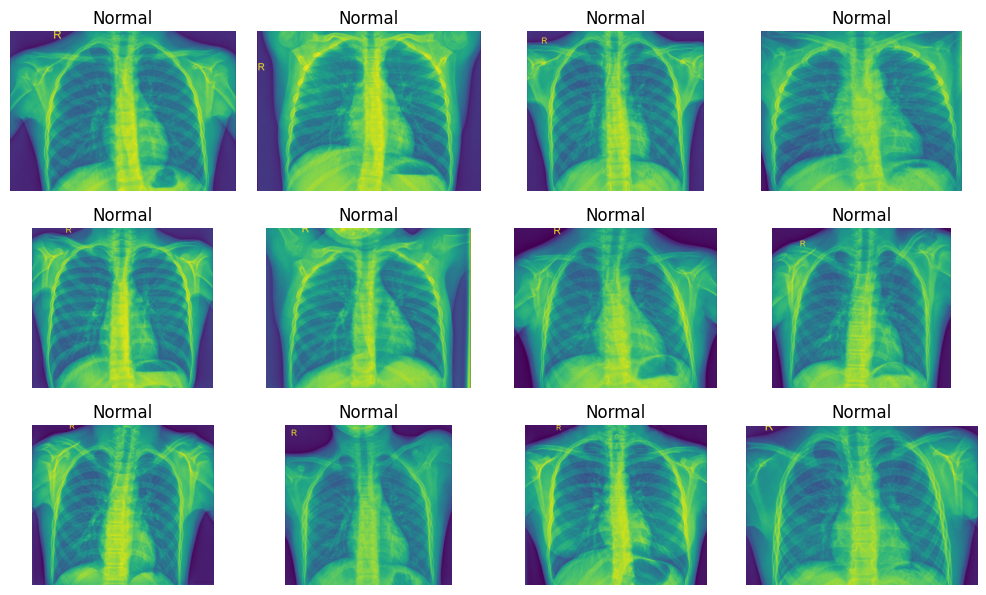

In [130]:
display_image(df=df[df["label"] == 0])

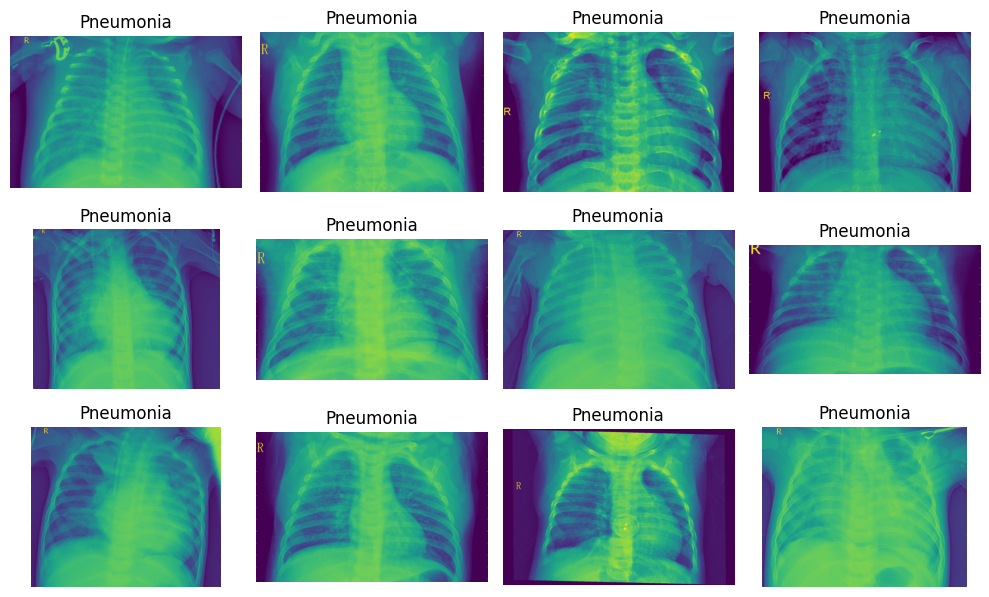

In [131]:
display_image(df=df[df["label"] == 1])

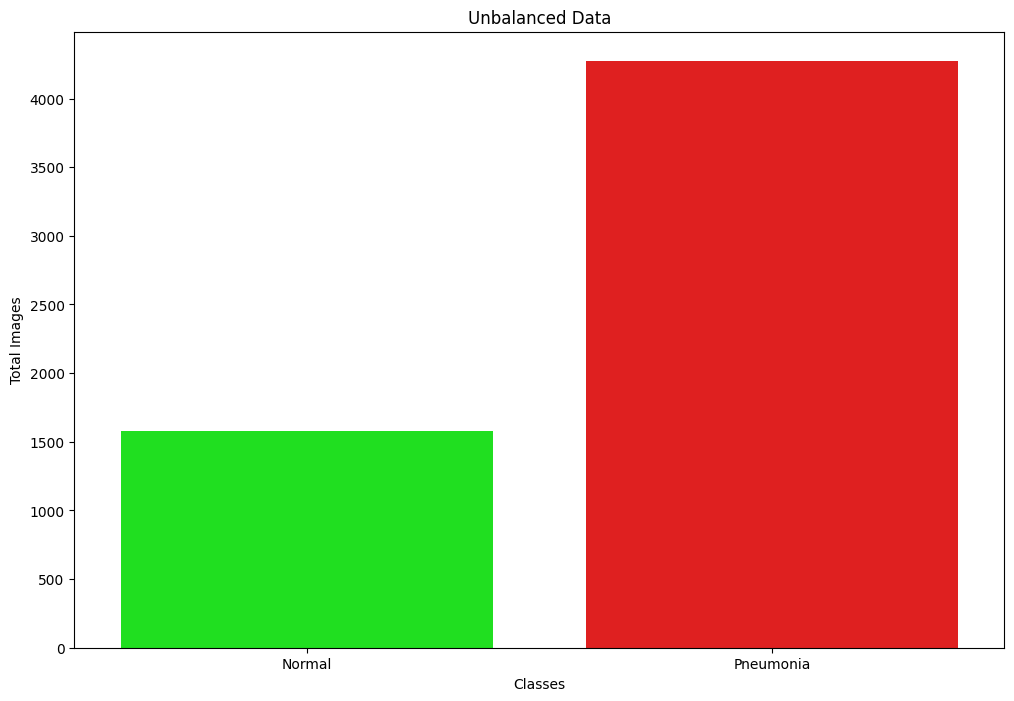

In [132]:
plt.figure(figsize=(12, 8))
sns.barplot(x=["Normal", "Pneumonia"], y=df["label"].value_counts().sort_index(), palette=["#00FF00", "#FF0000"])
plt.title("Unbalanced Data")
plt.xlabel("Classes")
plt.ylabel("Total Images")
plt.show()

In [146]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [169]:
IMG_SIZE = 150
target_count = len(df[df["label"] == 1])
df_minority = df[df["label"] == 0]
augmented_images = []

for _, row in df_minority.iterrows():
    if len(augmented_images) == target_count - len(df_minority):
        break
    
    img = cv2.imread(row["path"], cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resized = img_resized.reshape((1, IMG_SIZE, IMG_SIZE, 1))
    
    for batch in datagen.flow(img_resized, batch_size=1):
        augmented_images.append((batch[0].reshape(IMG_SIZE, IMG_SIZE), 0))
        if len(augmented_images) == target_count - len(df_minority):
            break

In [171]:
augmented_df = pd.DataFrame({
    "path": [None] * len(augmented_images),
    "label": [0] * len(augmented_images),
    "height": [150] * len(augmented_images),
    "width": [150] * len(augmented_images),
    "size_kb": [0] * len(augmented_images),
})

df_balanced = pd.concat([df, augmented_df])
print(df_balanced["label"].value_counts())

label
0    4273
1    4273
Name: count, dtype: int64


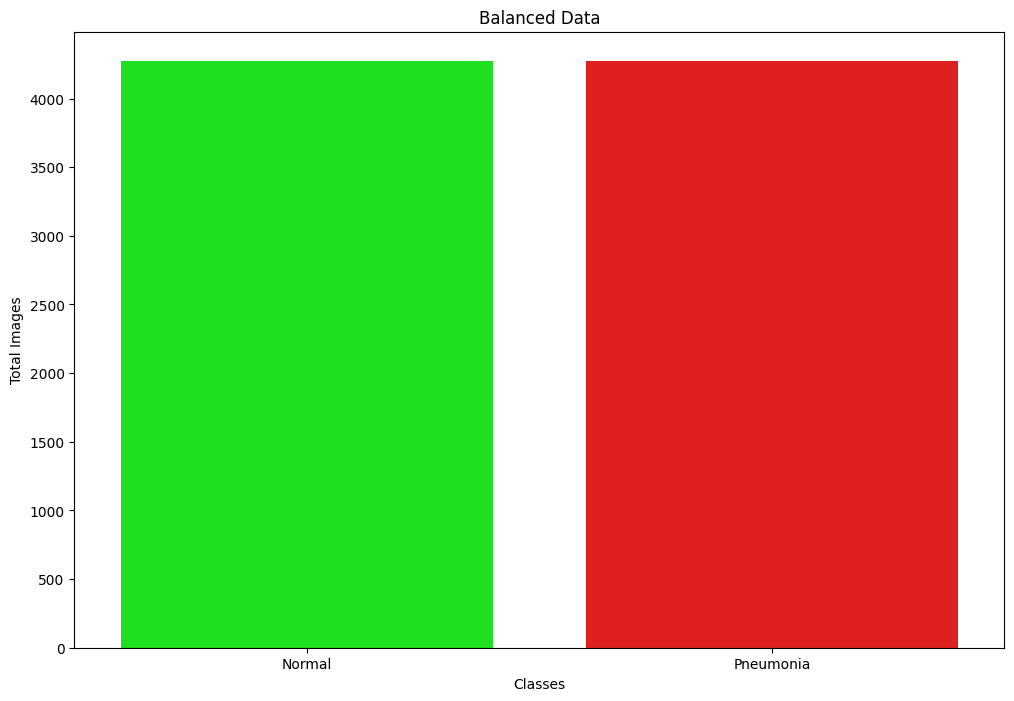

In [231]:
plt.figure(figsize=(12, 8))
sns.barplot(x=["Normal", "Pneumonia"], y=df_balanced['label'].value_counts().sort_index(), palette=["#00FF00", "#FF0000"])
plt.title("Balanced Data")
plt.xlabel("Classes")
plt.ylabel("Total Images")
plt.show()

In [173]:
IMG_SIZE = 150
images = []
labels = []

for _, row in df_balanced.iterrows():
    if row["path"] != "None" and row["path"] is not None:
        img = cv2.imread(row["path"], cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img_resized)
        labels.append(row["label"])
    else:
       if augmented_images:
            img_resized, label = augmented_images.pop(0)
            images.append(img_resized)
            labels.append(label)
        
X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = np.array(labels)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (8546, 150, 150, 1)
Shape of y: (8546,)


In [174]:
print(f"Balanced Label Distribution:\n{pd.Series(y).value_counts()}")

Balanced Label Distribution:
0    4273
1    4273
Name: count, dtype: int64


The dimensions of the image are 1317 pixels width and 1857 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 130.9986 and the standard deviation is 57.1020


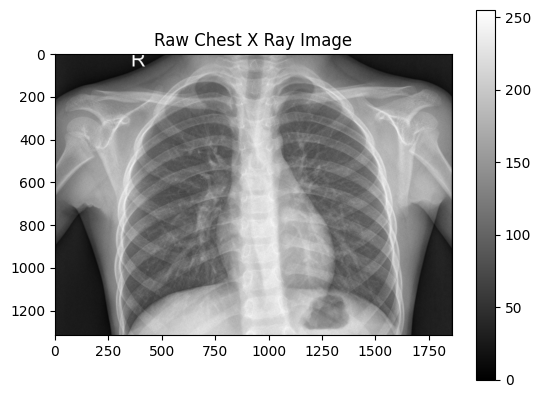

In [178]:
image_path = df["path"][0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {img.shape[0]} pixels width and {img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {img.max():.4f} and the minimum is {img.min():.4f}")
print(f"The mean value of the pixels is {img.mean():.4f} and the standard deviation is {img.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

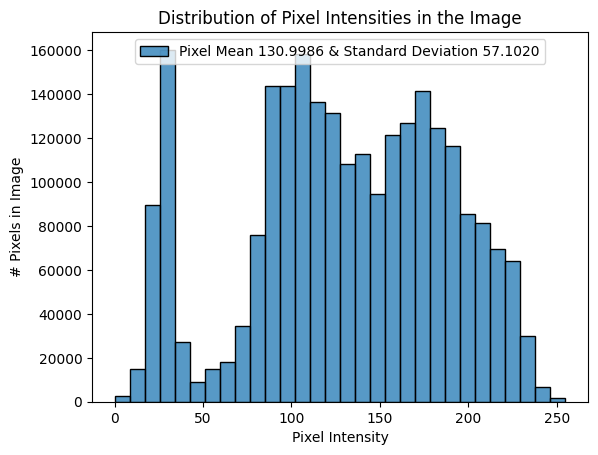

In [179]:
sns.histplot(
    img.ravel(),
    bins=30,
    label=f"Pixel Mean {np.mean(img):.4f} & Standard Deviation {np.std(img):.4f}", 
    kde=False
)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in train set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")


Train set size: 6836
Test set size: 1710
Class distribution in train set: [3418 3418]
Class distribution in test set: [855 855]


In [182]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [183]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test, y_test)
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 190s 847ms/step - accuracy: 0.7960 - loss: 0.4235 - val_accuracy: 0.9713 - val_loss: 0.0984
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 167s 778ms/step - accuracy: 0.9608 - loss: 0.1110 - val_accuracy: 0.9655 - val_loss: 0.1038
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 158s 740ms/step - accuracy: 0.9628 - loss: 0.0980 - val_accuracy: 0.9684 - val_loss: 0.1001
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 153s 716ms/step - accuracy: 0.9755 - loss: 0.0664 - val_accuracy: 0.9713 - val_loss: 0.0900
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 164s 767ms/step - accuracy: 0.9791 - loss: 0.0551 - val_accuracy: 0.9737 - val_loss: 0.0831
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 159s 745ms/step - accuracy: 0.9860 - loss: 0.0346 - val_accuracy: 0.9649 - val_loss: 0.1049
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 184s 859ms/step - accuracy: 0.9885 - loss: 0.0335 - val_accuracy: 0.9725 - val_loss: 0.0952
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 156s 727ms/step - accuracy: 0.9851 -

In [185]:
test_loss, test_acc = model.evaluate(X_test, y_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9715 - loss: 0.1028


In [186]:
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test accuracy: 0.9713
Test Loss: 0.1118


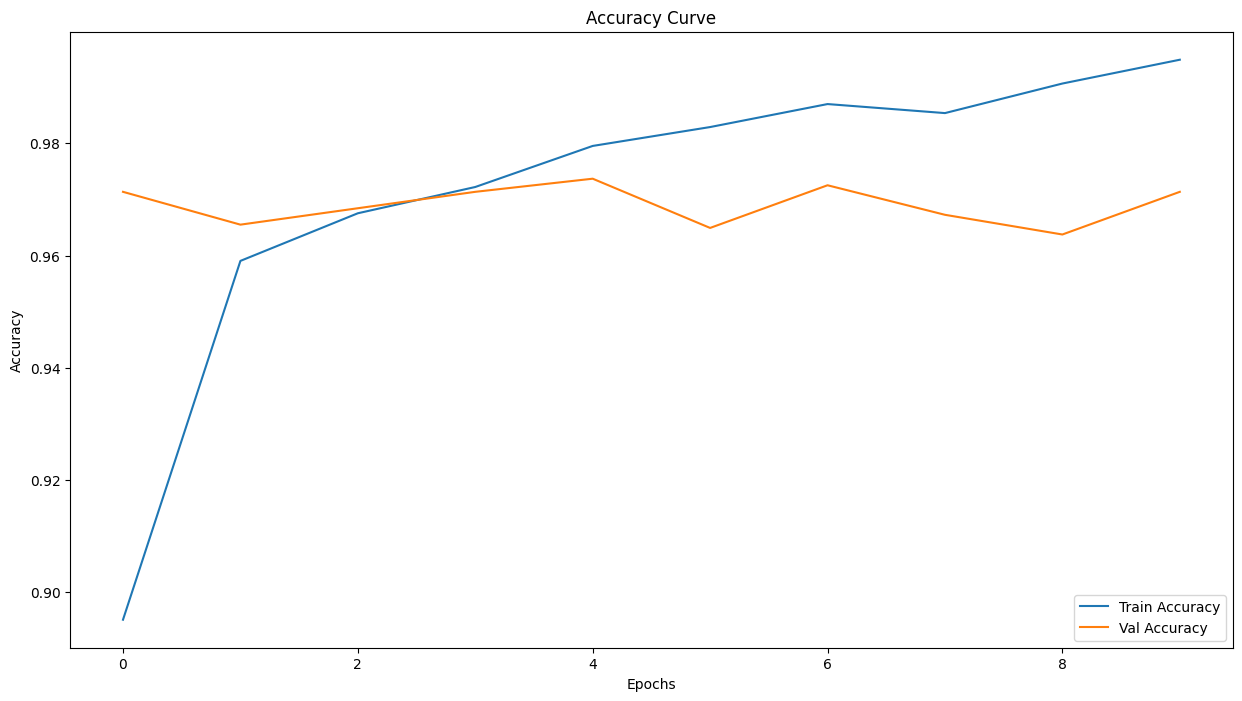

In [234]:
plt.figure(figsize=(15, 8))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(loc="lower right")
plt.show()

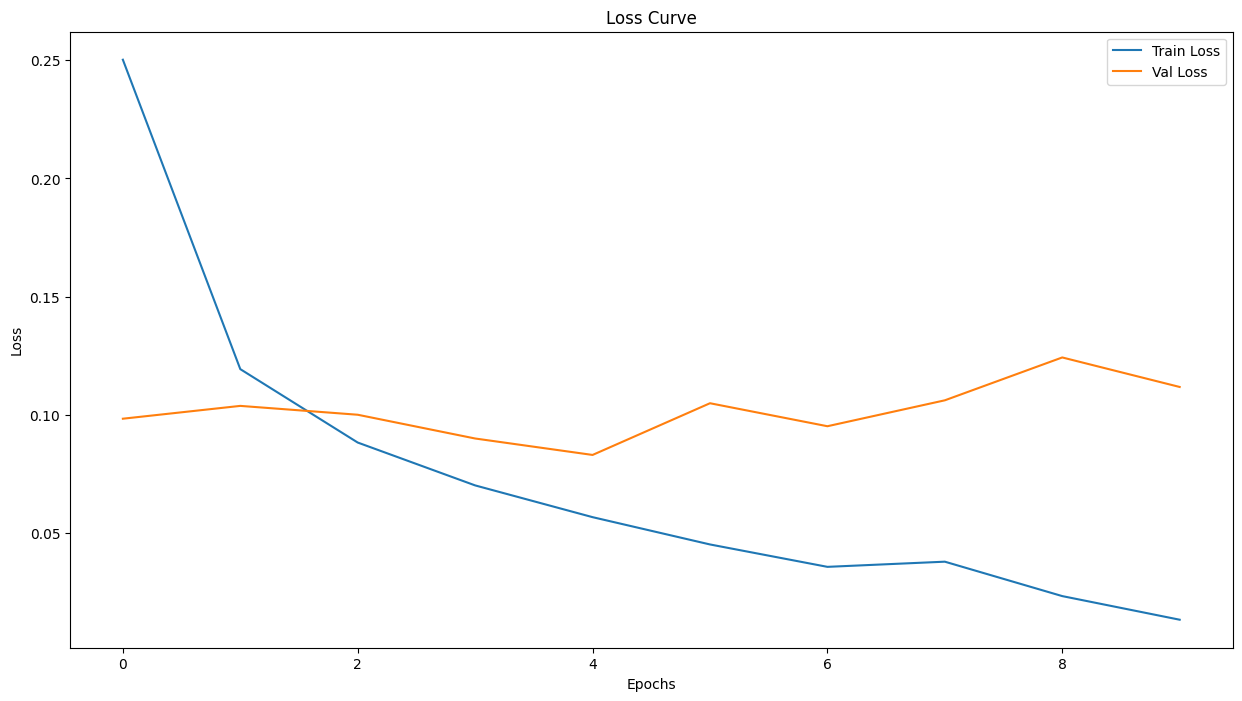

In [233]:
plt.figure(figsize=(15, 8))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(loc="upper right")
plt.show()

In [227]:
y_pred = model.predict(X_test)
y_pred= (y_pred > 0.5).astype(int) 

cm = confusion_matrix(y_test, y_pred)

54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step


In [235]:
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))

              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       855
   Pneumonia       0.98      0.97      0.97       855

    accuracy                           0.97      1710
   macro avg       0.97      0.97      0.97      1710
weighted avg       0.97      0.97      0.97      1710



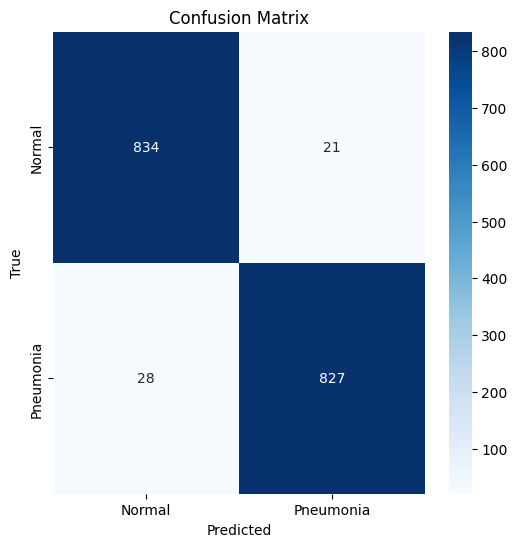

In [229]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

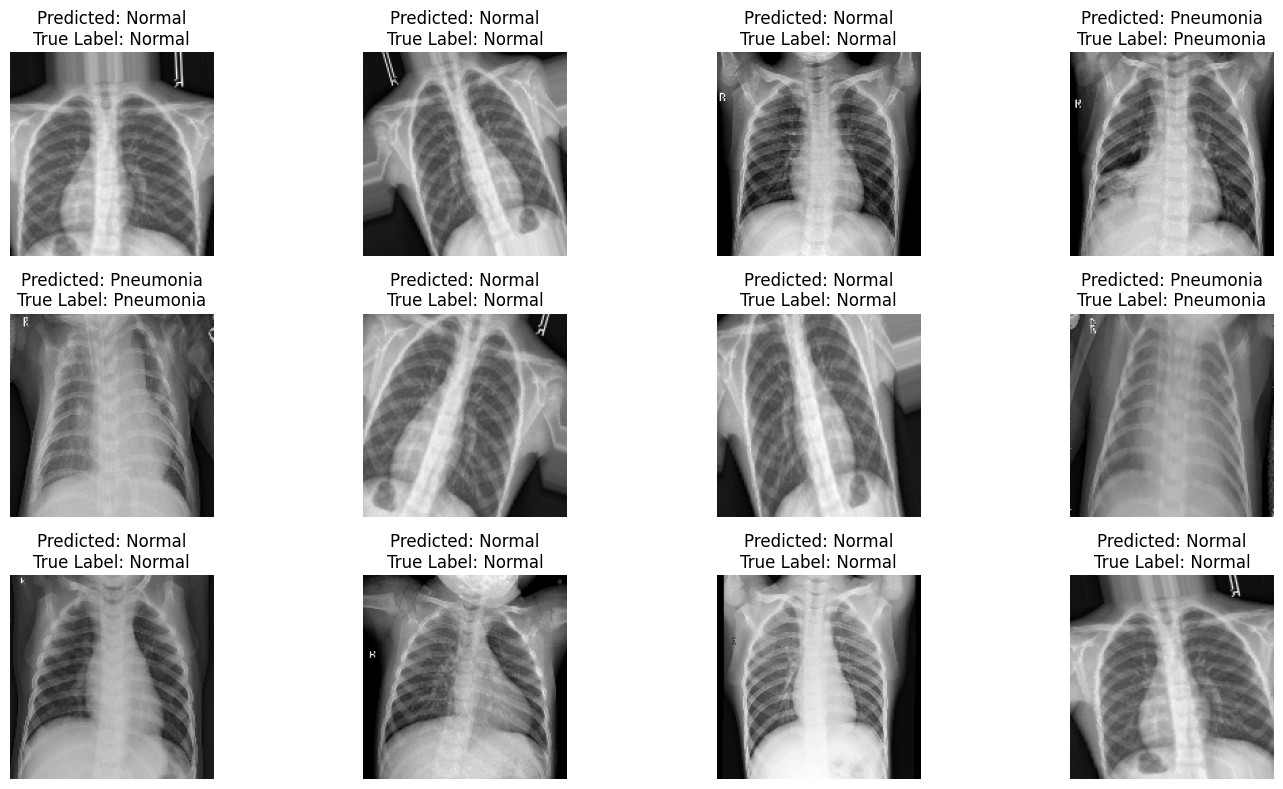

In [230]:
plt.figure(figsize=(15,8))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    predicted_label = "Normal" if y_pred[i] == 0 else "Pneumonia"
    true_label = "Normal" if y_test[i] == 0 else "Pneumonia"
    
    plt.imshow(X_test[i], cmap="gray")
    plt.title(f"Predicted: {predicted_label}\nTrue Label: {true_label}")
    plt.axis("off")
    
plt.tight_layout()
plt.show()
